In [11]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/thinned_mfld")

import sys
sys.path.append("/home/zongchen/thinned_mfld")
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=22, labelsize=22, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=18, direction='in')
plt.rc('ytick', labelsize=18, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [12]:
particle_num = 64
loading_freq = 1
zeta = 1.0
seed_list = [0, 1, 2, 3, 4, 5]
methods_list = ['random', 'false', 'kt']
bandwidth = 1.0
g = 0
noise_scale = 0.001
dataset = 'covertype'
# step_size = 3e-05
step_size = 1e-04
kernel = 'sobolev'

loss_trajectory_dict = {'kt': [], 'random': [], 'false': []}
mmd_dict = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict = {'kt': [], 'random': [], 'false': []}
kgd_dict = {'kt': [], 'random': [], 'false': []}

for method in methods_list:
    for seed in seed_list:
        if method == 'false' or method == 'random':
            dir =f"./results_server/neural_network_vlm/thinning_{method}/kernel_sobolev__step_size_{step_size}__bandwidth_1.0"
            dir += f"__step_num_200__g_0__particle_num_{particle_num}__noise_scale_{noise_scale}__zeta_{zeta}__seed_{seed}__complete"
        else:
            dir = f"./results_server/neural_network_vlm/thinning_{method}/kernel_{kernel}__step_size_{step_size}__bandwidth_{bandwidth}"
            dir += f"__step_num_200__g_{g}__particle_num_{particle_num}__noise_scale_{noise_scale}__zeta_{zeta}__seed_{seed}__complete"
        mmd_trajectory = jnp.load(f"{dir}/mmd_path.npy")
        thin_original_mse = jnp.load(f"{dir}/thin_original_mse_path.npy")
        loss = jnp.load(f"{dir}/vlm_loss.npy")
        kgd_trajectory = jnp.load(f"{dir}/vlm_kgd.npy")
        if seed == 0:
            loss_trajectory_dict[method] = loss[:, None]
            mmd_dict[method] = mmd_trajectory[:, None][::loading_freq]
            thin_original_mse_dict[method] = thin_original_mse[:, None][::loading_freq]
            kgd_dict[method] = kgd_trajectory[:, None][::loading_freq]
        else:
            loss_trajectory_dict[method] = jnp.concatenate([loss_trajectory_dict[method], loss[:, None]], axis=1)
            mmd_dict[method] = jnp.concatenate([mmd_dict[method], mmd_trajectory[:, None][::loading_freq]], axis=1)
            thin_original_mse_dict[method] = jnp.concatenate([thin_original_mse_dict[method], thin_original_mse[:, None][::loading_freq]], axis=1)
            kgd_dict[method] = jnp.concatenate([kgd_dict[method], kgd_trajectory[:, None][::loading_freq]], axis=1)


In [13]:
loss_trajectory_dict_mean = {'kt': [], 'random': [], 'false': []}
loss_trajectory_dict_ste = {'kt': [], 'random': [], 'false': []}
mmd_dict_mean = {'kt': [], 'random': [], 'false': []}
mmd_dict_ste = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict_mean = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict_ste = {'kt': [], 'random': [], 'false': []}
kgd_mean = {'kt': [], 'random': [], 'false': []}
kgd_ste = {'kt': [], 'random': [], 'false': []}

for method in methods_list:
    loss_trajectory_dict_mean[method] = np.nanmean(loss_trajectory_dict[method], axis=1)
    loss_trajectory_dict_ste[method] = np.nanstd(loss_trajectory_dict[method], axis=1) / np.sqrt(loss_trajectory_dict[method].shape[1])
    mmd_dict_mean[method] = np.nanmean(mmd_dict[method], axis=1)
    mmd_dict_ste[method] = np.nanstd(mmd_dict[method], axis=1) / np.sqrt(mmd_dict[method].shape[1])
    thin_original_mse_dict_mean[method] = np.nanmean(thin_original_mse_dict[method], axis=1)
    thin_original_mse_dict_ste[method] = np.nanstd(thin_original_mse_dict[method], axis=1) / np.sqrt(thin_original_mse_dict[method].shape[1])   

    kgd_mean[method] = np.nanmean(kgd_dict[method], axis=1)
    kgd_ste[method] = np.nanstd(kgd_dict[method], axis=1) / np.sqrt(kgd_dict[method].shape[1])
    

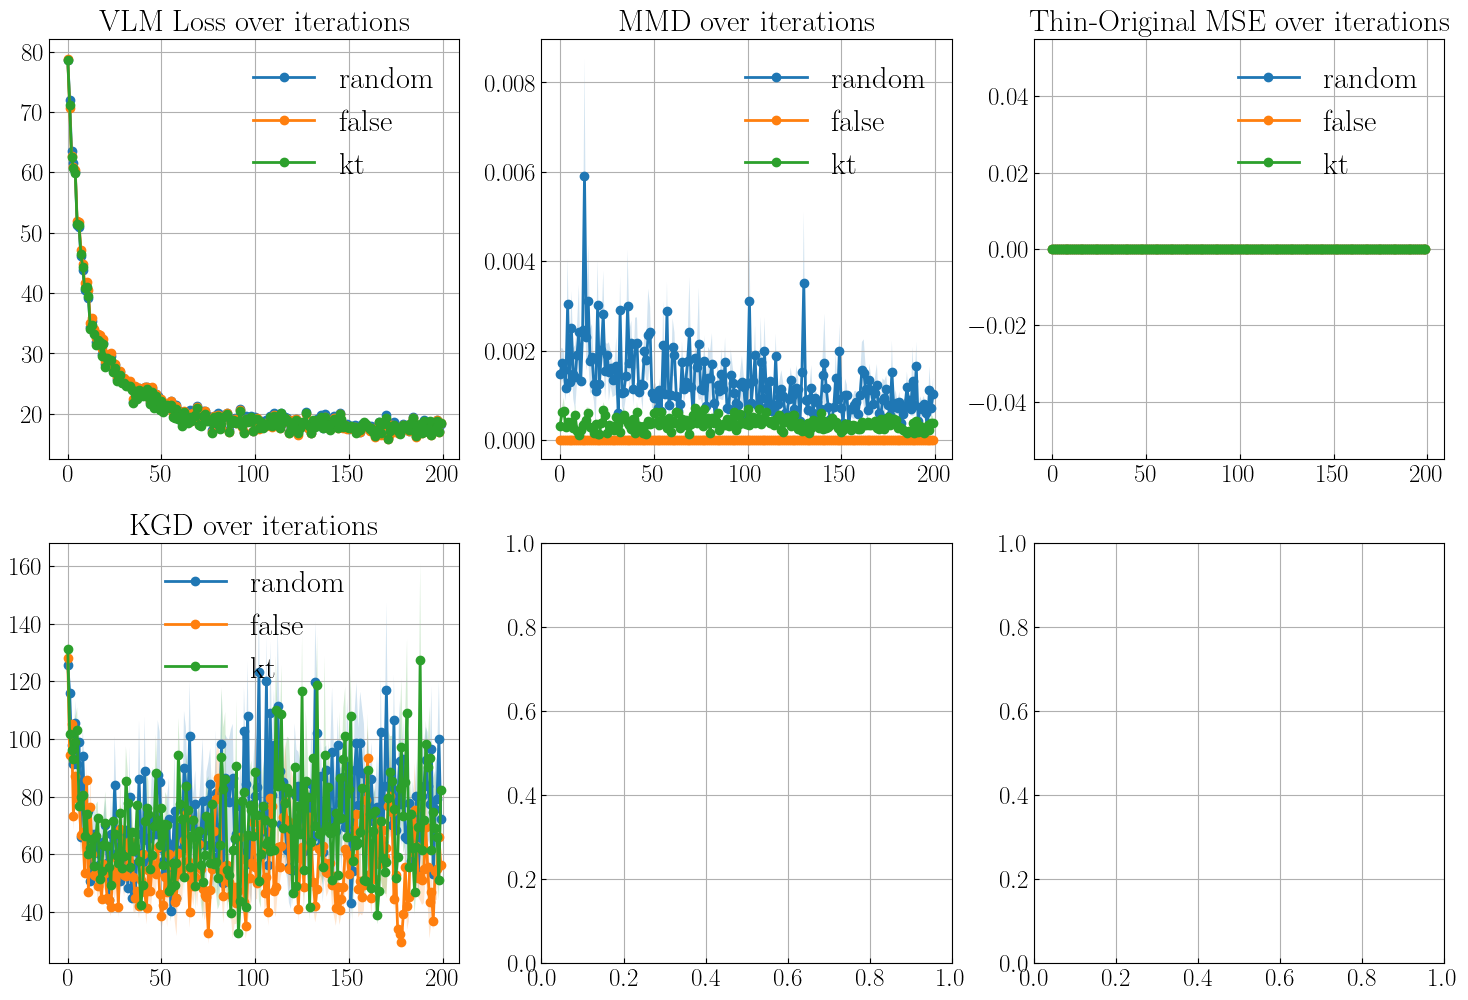

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()
axs[0].grid(True)

for method in methods_list:
    axs[0].plot(jnp.arange(loss_trajectory_dict_mean[method].shape[0]), loss_trajectory_dict_mean[method], label=method, marker='o')
    axs[0].fill_between(jnp.arange(loss_trajectory_dict_mean[method].shape[0]), loss_trajectory_dict_mean[method] - loss_trajectory_dict_ste[method], 
                        loss_trajectory_dict_mean[method] + loss_trajectory_dict_ste[method], alpha=0.2)
    axs[0].legend()
    axs[0].set_title("VLM Loss over iterations")
    # axs[0].set_yscale('log')

for method in methods_list:
    axs[1].plot(jnp.arange(mmd_dict_mean[method].shape[0]), mmd_dict_mean[method], label=method, marker='o')
    axs[1].fill_between(jnp.arange(mmd_dict_mean[method].shape[0]), mmd_dict_mean[method] - mmd_dict_ste[method], 
                        mmd_dict_mean[method] + mmd_dict_ste[method], alpha=0.2)
    axs[1].legend()
    axs[1].set_title("MMD over iterations")

for method in methods_list:
    axs[2].plot(jnp.arange(thin_original_mse_dict_mean[method].shape[0]), thin_original_mse_dict_mean[method], label=method, marker='o')
    axs[2].fill_between(jnp.arange(thin_original_mse_dict_mean[method].shape[0]), thin_original_mse_dict_mean[method] - thin_original_mse_dict_ste[method], 
                        thin_original_mse_dict_mean[method] + thin_original_mse_dict_ste[method], alpha=0.2)
    axs[2].legend()
    axs[2].set_title("Thin-Original MSE over iterations")

for method in methods_list:
    axs[3].plot(jnp.arange(kgd_mean[method].shape[0]), kgd_mean[method], label=method, marker='o')
    axs[3].fill_between(jnp.arange(kgd_mean[method].shape[0]), kgd_mean[method] - kgd_ste[method], 
                        kgd_mean[method] + kgd_ste[method], alpha=0.2)
    axs[3].legend()
    axs[3].set_title("KGD over iterations")
    # axs[3].set_yscale('log')
plt.show()
